### Memory Networks

In [1]:
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import re
import tarfile

from keras.models import Model
from keras.layers import Dense,Embedding,Input,Lambda,Reshape,add,dot,Activation
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam,RMSprop
from keras.utils.data_utils import get_file

Using TensorFlow backend.


In [2]:
# get the data and open compressed file
# path = get_file('babi-tasks-v1-2.tar.gz',
#                 origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
!wget https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz

--2019-08-12 09:00:20--  https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.144.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.144.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11745123 (11M) [application/x-gzip]
Saving to: ‘babi_tasks_1-20_v1-2.tar.gz.1’

babi_tasks_1-20_v1- 100%[===================>]  11.20M  6.04MB/s    in 1.9s    

2019-08-12 09:00:23 (6.04 MB/s) - ‘babi_tasks_1-20_v1-2.tar.gz.1’ saved [11745123/11745123]



In [0]:
tar = tarfile.open('babi_tasks_1-20_v1-2.tar.gz')
tar.extractall()

In [0]:
# dict to get relevant data from tar file
challenges = {
    'single_supporting_fact_10k':'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    'two_supporting_facts_10k':'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'
}

In [0]:
def tokenize(sent):
  # returns the tokens of a sentence including punctuation
  return [x.strip() for x in re.split('(\W+)?',sent) if x.strip()]

In [0]:
def get_stories(f):
  # data will return a list of triples
  # each triple contains:
  # 1. a story
  # 2. a question about the story
  # 3. the answer to the question
  data = []
  story = []
  
  for line in f:
    line = line.decode('utf-8').strip()
    nid, line = line.split(' ',1)
    
    if int(nid) == 1: # begin a new story
      story = []
    
    if '\t' in line: # this line contains a ques and answer
      q, a, _ = line.split('\t')
      q = tokenize(q)
      story_so_far = [[str(i)]+s for i,s in enumerate(story) if s]
      
      data.append((story_so_far, q, a))
      story.append('')
    else:
      story.append(tokenize(line))
  print(len(data))
    
  return data

In [0]:
# recursively flatten a list
def should_flatten(el):
  return not isinstance(el, (str,bytes))

def flatten(l):
  for el in l:
    if should_flatten(el):
      yield from flatten(el)
    else:
      yield el

In [0]:
def vectorize_stories(data, word2idx, story_maxlen, query_maxlen):
  inputs, queries, answers = [],[],[]
  for story,query,answer in data:
    inputs.append([[word2idx[w] for w in s] for s in story])
    queries.append([word2idx[w] for w in query])
    answers.append([word2idx[answer]])
  
  return ([pad_sequences(x,maxlen=story_maxlen) for x in inputs],
          pad_sequences(queries,maxlen=query_maxlen),
          np.array(answers))

In [0]:
# padding stories so that every story has same
# no. of sentences
def stack_inputs(inputs, story_maxsents, story_maxlen):
  for i, story in enumerate(inputs):
    inputs[i] = np.concatenate(
      [
        story, 
        np.zeros((story_maxsents - story.shape[0], story_maxlen), 'int')
      ]
    )
  return np.stack(inputs)

In [0]:
def get_data(challenge_type):
  # to laod both ssf and tsf data
  challenge = challenges[challenge_type]
  
  train_stories = get_stories(tar.extractfile(challenge.format('train')))
  test_stories = get_stories(tar.extractfile(challenge.format('test')))
  
  print(len(train_stories),len(test_stories))
  stories = train_stories + test_stories
  
  story_maxlen = max((len(s) for x,_,_ in stories for s in x)) 
  story_maxsents = max((len(x) for x,_,_ in stories))
  query_maxlen = max(len(x) for _,x,_ in stories)
  
  vocab = sorted(set(flatten(stories)))
  vocab.insert(0, '<PAD>')
  vocab_size = len(vocab)
  
  word2idx = {c:i for i,c in enumerate(vocab)}
  
  inputs_train, queries_train, answers_train = vectorize_stories(
                                               train_stories,
                                               word2idx,
                                               story_maxlen,
                                               query_maxlen)
  inputs_test, queries_test, answers_test = vectorize_stories(
                                               test_stories,
                                               word2idx,
                                               story_maxlen,
                                               query_maxlen)

  inputs_train = stack_inputs(inputs_train,story_maxsents,story_maxlen)
  inputs_test = stack_inputs(inputs_test,story_maxsents,story_maxlen)
  
  print('Inputs Train shape, Inputs Test shape:',inputs_train.shape,
                                                 inputs_test.shape)
  
  return (train_stories,test_stories,inputs_train,queries_train,
          answers_train,inputs_test,queries_test,answers_test,
          story_maxsents,story_maxlen,query_maxlen,vocab,vocab_size)

In [11]:
# get the ssf data
train_stories, test_stories, \
  inputs_train, queries_train, answers_train, \
  inputs_test, queries_test, answers_test, \
  story_maxsents, story_maxlen, query_maxlen, \
  vocab, vocab_size = get_data('single_supporting_fact_10k')

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


10000
1000
10000 1000
Inputs Train shape, Inputs Test shape: (10000, 10, 8) (1000, 10, 8)


In [12]:
## create the model
embedding_dim = 15

input_story_ = Input((story_maxsents, story_maxlen))
embedded_story = Embedding(vocab_size,embedding_dim)(input_story_)
embedded_story = Lambda(lambda x:K.sum(x,axis=2))(embedded_story)
print('Input Story shape, Embedded Story shape',input_story_.shape,
                                                embedded_story.shape)

W0812 09:00:28.034842 140134442682240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 09:00:28.053388 140134442682240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 09:00:28.058599 140134442682240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Input Story shape, Embedded Story shape (?, 10, 8) (?, 10, 15)


In [0]:
input_question_ = Input((query_maxlen,))
embedded_question = Embedding(vocab_size,embedding_dim)(input_question_)
embedded_question = Lambda(lambda x:K.sum(x,axis=1))(embedded_question)

In [14]:
# to dot with story we add a sequence length of 1 to ques
embedded_question = Reshape((1,embedding_dim))(embedded_question)
print('Input ques shape, Embedded ques shape',input_question_.shape,
                                              embedded_question.shape)

Input ques shape, Embedded ques shape (?, 4) (?, 1, 15)


In [15]:
# calculate weights for each story line
x = dot([embedded_story, embedded_question],2)
x = Reshape((story_maxsents,))(x) # flatten
x = Activation('softmax')(x)
story_weights = Reshape((story_maxsents,1))(x) # unflatten to dot later
print('Story weights shape',story_weights.shape)

Story weights shape (?, 10, 1)


In [0]:
x = dot([story_weights,embedded_story], 1)
x = Reshape((embedding_dim,))(x)
ans = Dense(vocab_size,activation='softmax')(x)

In [0]:
# make the model
model = Model([input_story_,input_question_],ans)

In [0]:
# compile the model
model.compile(optimizer=RMSprop(lr=1e-2),
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])

In [19]:
# train the model
r = model.fit([inputs_train,queries_train],
              answers_train,
              epochs=4,
              batch_size=32,
              validation_data=([inputs_test,queries_test],answers_test))

W0812 09:00:28.407648 140134442682240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0812 09:00:28.547237 140134442682240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 10000 samples, validate on 1000 samples
Epoch 1/4
10000/10000 [==============================] - 2s 239us/step - loss: 0.7161 - acc: 0.7532 - val_loss: 0.0222 - val_acc: 0.9940
Epoch 2/4
10000/10000 [==============================] - 1s 146us/step - loss: 0.0122 - acc: 0.9970 - val_loss: 0.0038 - val_acc: 0.9990
Epoch 3/4
10000/10000 [==============================] - 1s 147us/step - loss: 0.0055 - acc: 0.9988 - val_loss: 1.4598e-05 - val_acc: 1.0000
Epoch 4/4
10000/10000 [==============================] - 1s 146us/step - loss: 0.0064 - acc: 0.9984 - val_loss: 1.4428e-05 - val_acc: 1.0000


In [20]:
# check how we weight each input sentence given a story and question
debug_model = Model([input_story_,input_question_],story_weights)

story_idx = np.random.choice(len(train_stories))

# get weights from debug model
i = inputs_train[story_idx:story_idx+1]
q = queries_train[story_idx:story_idx+1]
w = debug_model.predict([i,q]).flatten()

story,question,ans = train_stories[story_idx]
print('Story:')
for i,line in enumerate(story):
  print('{:1.5f}'.format(w[i]),' '.join(line))

print('question:',' '.join(question))
print('answer:',ans)

Story:
0.00000 0 Daniel moved to the bedroom .
0.00044 1 Mary moved to the office .
0.00742 3 Mary travelled to the bedroom .
0.00000 4 Sandra journeyed to the bathroom .
0.99209 6 Mary journeyed to the hallway .
0.00005 7 John moved to the hallway .
question: Where is Mary ?
answer: hallway


In [21]:
# get the tsf data
train_stories, test_stories, \
  inputs_train, queries_train, answers_train, \
  inputs_test, queries_test, answers_test, \
  story_maxsents, story_maxlen, query_maxlen, \
  vocab, vocab_size = get_data('two_supporting_facts_10k')

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


10000
1000
10000 1000
Inputs Train shape, Inputs Test shape: (10000, 88, 8) (1000, 88, 8)


In [0]:
# create the model
embedding_dim = 30

In [0]:
def embed_and_sum(x,axis=2):
  x = Embedding(vocab_size, embedding_dim)(x)
  x = Lambda(lambda x:K.sum(x,axis))(x)
  return x

In [0]:
input_story_ = Input((story_maxsents,story_maxlen))
input_question_ = Input((query_maxlen,))

In [0]:
# embed the inputs
embedded_story = embed_and_sum(input_story_)
embedded_question = embed_and_sum(input_question_, 1)

In [0]:
dense_layer = Dense(embedding_dim, activation='elu')

In [0]:
# define one hop
# the 'query' can be the ques, or ans from prev hop
def hop(query, story):
  # query shape = (embedding_dim,)
  # story shape = (num_sentences, embedding_dim)
  x = Reshape((1,embedding_dim))(query)
  x = dot([story,x],2)
  x = Reshape((story_maxsents,))(x)
  x = Activation('softmax')(x)
  story_weights = Reshape((story_maxsents,1))(x)
  
  # make a new embedding
  story_embedding2 = embed_and_sum(input_story_)
  x = dot([story_weights,story_embedding2],1)
  x = Reshape((embedding_dim,))(x)
  x = dense_layer(x)
  return x, story_embedding2, story_weights

In [0]:
# do the hops
ans1, embedded_story, story_weights1 = hop(embedded_question, embedded_story)
ans2, _, story_weights2 = hop(ans1, embedded_story)

In [0]:
# get the final answer
ans = Dense(vocab_size, activation='softmax')(ans2)

In [0]:
# build the model
model2 = Model([input_story_, input_question_], ans)

# compile the model
model2.compile(optimizer=RMSprop(lr=5e-3),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [32]:
# fit the model
r = model2.fit([inputs_train, queries_train],
               answers_train,
               epochs=30,
               batch_size=32,
               validation_data=([inputs_test,queries_test],answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/30
10000/10000 [==============================] - 3s 347us/step - loss: 1.7549 - acc: 0.2542 - val_loss: 1.5495 - val_acc: 0.3530
Epoch 2/30
10000/10000 [==============================] - 3s 309us/step - loss: 0.9835 - acc: 0.6167 - val_loss: 0.7000 - val_acc: 0.7180
Epoch 3/30
10000/10000 [==============================] - 3s 306us/step - loss: 0.6382 - acc: 0.7551 - val_loss: 0.6111 - val_acc: 0.7520
Epoch 4/30
10000/10000 [==============================] - 3s 308us/step - loss: 0.5255 - acc: 0.8042 - val_loss: 0.5883 - val_acc: 0.7680
Epoch 5/30
10000/10000 [==============================] - 3s 306us/step - loss: 0.4303 - acc: 0.8458 - val_loss: 0.5429 - val_acc: 0.8200
Epoch 6/30
10000/10000 [==============================] - 3s 318us/step - loss: 0.3686 - acc: 0.8755 - val_loss: 0.3931 - val_acc: 0.8570
Epoch 7/30
10000/10000 [==============================] - 3s 307us/step - loss: 0.3162 - acc: 0.8909 - val_loss: 0.4039 - v

In [0]:
# print the story line weights again
debug_model2 = Model([input_story_,input_question_],
                     [story_weights1, story_weights2])

In [0]:
# choose a random story
story_idx = np.random.choice(len(train_stories))

# get weights from debug model
i = inputs_train[story_idx:story_idx+1]
q = queries_train[story_idx:story_idx+1]
w1,w2 = debug_model2.predict([i,q])
w1 = w1.flatten()
w2 = w2.flatten()

In [41]:
story,question,ans = train_stories[story_idx]
print('Story:')
for j,line in enumerate(story):
  print('{:1.5f}'.format(w1[j]),'{:1.5f}'.format(w2[j]),' '.join(line))

print('question:',' '.join(question))
print('answer:',ans)
print('prediction:',vocab[np.argmax(model2.predict([i,q])[0])])

Story:
0.00000 0.00000 0 Mary journeyed to the garden .
0.00000 0.00000 1 Sandra went to the hallway .
0.00000 0.00000 2 Mary went to the bathroom .
0.00000 0.00000 3 John journeyed to the office .
0.00000 0.00000 4 Sandra went back to the garden .
0.00000 0.00000 5 Sandra journeyed to the bathroom .
0.00000 0.00000 6 Mary moved to the office .
0.00000 0.00000 7 Daniel moved to the garden .
0.00000 0.00000 8 Daniel travelled to the bathroom .
0.00000 0.00000 9 Mary travelled to the garden .
0.00000 0.00000 10 John journeyed to the hallway .
0.00000 0.00000 11 Sandra travelled to the kitchen .
0.00000 0.00000 12 Sandra went back to the garden .
0.00000 0.00000 13 Mary moved to the hallway .
0.00000 0.00000 14 Sandra journeyed to the hallway .
0.00000 0.00000 15 Mary journeyed to the bedroom .
0.00000 0.00000 16 Mary moved to the hallway .
0.00000 0.00019 17 Daniel went back to the kitchen .
0.00000 0.00000 18 John travelled to the kitchen .
0.00000 0.10124 19 Daniel went back to the bed

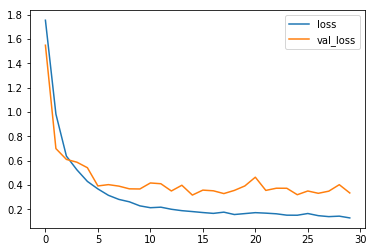

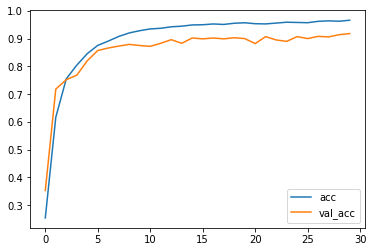

In [42]:
# plot the results
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()